In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import chainer
import chainer.links as L
import chainer.functions as F

In [32]:
import numpy as np
import os
import cv2

imgSrc = ""
def getDataSet():
    
    # dataset
    train_imgs = []
    train_labels = []

    
    # ファイルリスト取得
    f = open('train/train_labels.txt')
    imgList = f.readlines()
    
    for img in imgList:
        items = img.split(" ") 
        
        # 画像データの読み込
        imgSrc = cv2.imread("train/images/" + items[0], 0)
        train_imgs.append(imgSrc)
        
        # クラスの読み込み
        train_labels.append(items[1])
    
    return train_imgs,train_labels

# データ・セットの読み込み
train_imgs, train_labels = getDataSet()



TypeError: Image data can not convert to float

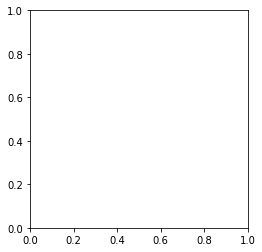

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.imshow(imgSrc)

In [12]:
len(train_imgs)

10536

In [27]:
train_imgs[0].shape

(950, 930)

In [28]:
train_imgs[0].dtype

dtype('uint8')

In [29]:
train_imgs2 = np.array(train_imgs).astype(np.float32)

ValueError: setting an array element with a sequence.

In [22]:
train_labels = np.array(train_labels).astype(np.int32)


In [10]:
from chainer.datasets import tuple_dataset

In [4]:
len(train)

50000

In [5]:
len(test)

10000

In [6]:
len(train[0])

2

In [7]:
type(train[0][0])

numpy.ndarray

In [8]:
train[0][0].shape

(3, 32, 32)

In [9]:
train[0][0].dtype

dtype('float32')

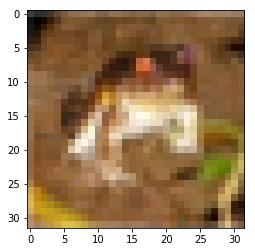

In [10]:
img = np.transpose(train[0][0], (1, 2, 0))
plt.imshow(img)

In [11]:
type(train[0][1])

numpy.int32

In [12]:
train[0][1].shape

()

In [19]:
train[0][1].dtype

dtype('int32')

In [17]:
train[0][1]

6

# モデルの定義

In [20]:
class Block(chainer.Chain):

    def __init__(self, out_channels, ksize, pad=1):
        super(Block, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, out_channels, ksize, pad=pad,
                                        nobias=True)
            self.bn = L.BatchNormalization(out_channels)

    def __call__(self, x):
        h = self.conv(x)
        h = self.bn(h)
        return F.relu(h)

In [21]:
class VGG(chainer.Chain):

    def __init__(self, class_labels=10):
        super(VGG, self).__init__()
        with self.init_scope():
            self.block1_1 = Block(64, 3)
            self.block1_2 = Block(64, 3)
            self.block2_1 = Block(128, 3)
            self.block2_2 = Block(128, 3)
            self.block3_1 = Block(256, 3)
            self.block3_2 = Block(256, 3)
            self.block3_3 = Block(256, 3)
            self.block4_1 = Block(512, 3)
            self.block4_2 = Block(512, 3)
            self.block4_3 = Block(512, 3)
            self.block5_1 = Block(512, 3)
            self.block5_2 = Block(512, 3)
            self.block5_3 = Block(512, 3)
            self.fc1 = L.Linear(None, 512, nobias=True)
            self.bn_fc1 = L.BatchNormalization(512)
            self.fc2 = L.Linear(None, class_labels, nobias=True)

    def __call__(self, x):

        # 64 channel blocks:
        h = self.block1_1(x)
        h = F.dropout(h, ratio=0.3)
        h = self.block1_2(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2)

        # 128 channel blocks:
        h = self.block2_1(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block2_2(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2)

        # 256 channel blocks:
        h = self.block3_1(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block3_2(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block3_3(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2)

        # 512 channel blocks:
        h = self.block4_1(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block4_2(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block4_3(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2)

        # 512 channel blocks:
        h = self.block5_1(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block5_2(h)
        h = F.dropout(h, ratio=0.4)
        h = self.block5_3(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2)

        h = F.dropout(h, ratio=0.5)
        h = self.fc1(h)
        h = self.bn_fc1(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)
        return self.fc2(h)

# シードの固定

In [22]:
def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

# モデルとそのほかの設定

In [23]:
# シードを固定（CPU＋GPU）
reset_seed(0)

# モデルの宣言
model = L.Classifier(VGG())

In [24]:
# Optimizerおよびオプションの設定
optimizer = chainer.optimizers.MomentumSGD(0.05)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(5e-4))

In [25]:
# Training parameter
epoch = 50
batchsize = 4096  # バッチサイズは大きめに設定

from chainer import training
from chainer.training import extensions

# Iterator
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# Set up a trainer
updater = training.updaters.ParallelUpdater(train_iter, optimizer, devices={'main': 0, '1st': 1, '2nd': 2, '3rd': 3})
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/cifar10')

trainer.extend(extensions.Evaluator(test_iter, model, device=0))  # Evaluatorはどれかmainなどで使っているGPUを指定すればよい

# Reduce the learning rate by half every 25 epochs.
trainer.extend(extensions.ExponentialShift('lr', 0.5), trigger=(25, 'epoch'))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot at each epoch
trainer.extend(extensions.snapshot(), trigger=(epoch, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

trainer.extend(extensions.PrintReport(
    ['epoch',  'elapsed_time', 'lr', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy',]))

# Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

RuntimeError: CUDA environment is not correctly set up
(see https://github.com/chainer/chainer#installation).No module named 'cupy'